# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "/content/drive/My Drive/final.sqlite" "final.sqlite"

In [5]:
import os
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")
    
print("Preprocessed Amzon fine food data columns  shape : ",final.shape)
print("fPreprocessed Amzon fine food data columns       :",final.columns.values)

Preprocessed Amzon fine food data columns  shape :  (364171, 12)
fPreprocessed Amzon fine food data columns       : ['index' 'Id' 'ProductId' 'UserId' 'ProfileName' 'HelpfulnessNumerator'
 'HelpfulnessDenominator' 'Score' 'Time' 'Summary' 'Text' 'CleanedText']


In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 3137.37it/s]


In [0]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [6]:
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

preprocessed_reviews=final['CleanedText']
score=final['Score']
X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews, score, test_size=0.33, random_state=42)

X_train.shape


(243994,)

In [7]:
#BoW
count_vect = CountVectorizer(max_df=0.95, min_df=2,stop_words='english') #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

X_train_bow = count_vect.transform(X_train)
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words ", X_train_bow.get_shape()[1])

X_test_bow = count_vect.transform(X_test)
print("the type of count vectorizer ",type(X_test_bow))
print("the shape of out text BOW vectorizer ",X_test_bow.get_shape())
print("the number of unique words ", X_test_bow.get_shape()[1])

some feature names  ['aaa', 'aaaaah', 'aaaand', 'aaah', 'aachen', 'aaf', 'aafco', 'aah', 'aamazoncom', 'aand']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (243994, 49398)
the number of unique words  49398
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (120177, 49398)
the number of unique words  49398


In [8]:
print(X_train_bow.shape,X_test_bow.shape,y_train.shape,y_test.shape)

(243994, 49398) (120177, 49398) (243994,) (120177,)


In [0]:
from sklearn.model_selection import cross_validate
#from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from tqdm import tqdm
def naive_bayes(X_train, Y_train,x_test,y_test):
    
    alpha_values = [0.0001,0.001,0.01,0.1,1,10,100]    
    
    # empty list that will hold cv scores
    train_score=[]
    test_score = []

    # perform 10-fold cross validation
    for alpha in tqdm(alpha_values):
        mnb = MultinomialNB(alpha = alpha)
        scores = cross_validate(mnb, X_train, Y_train, cv = 10,return_train_score=True, scoring = 'roc_auc')
        #cv_scores.append(scores.mean())
        test_score.append(scores['test_score'].mean())
        train_score.append(scores['train_score'].mean())
        #scores = cross_validate(clf, iris.data, iris.target, scoring=scoring,
        #                 cv=5, return_train_score=False)
        #sorted(scores.keys())

        #scores['test_recall_macro']                       

    test_score=list(map(lambda x:round(x,2),test_score))
    train_score=list(map(lambda x:round(x,2),train_score)) 

    # changing to misclassification error
    MSE_train = [1 - x for x in train_score]
    MSE_test  = [1 - x for x in test_score]
    #print(MSE)
    # determining best alpha
    optimal_alpha = alpha_values[MSE_test.index(min(MSE_test))]
    print('\nThe optimal number of alpha is %d.' % optimal_alpha)

    # plot misclassification error vs alpha
    plt.plot(alpha_values, MSE_train, marker = '*',color='red',label='train')
    plt.plot(alpha_values, MSE_test, marker = '*',color='orange',label='test')

    #for xy in zip(alpha_values, np.round(MSE,3)):
        #plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title("Misclassification Error vs alpha")
    plt.xlabel('value of alpha')
    plt.ylabel('Misclassification Error')
    plt.show()
    
    #print("the misclassification error for each value of alpha is : ", np.round(MSE,3))
    #optimal_alpha_code(optimal_alpha,X_train,Y_train,x_test,y_test,vect_method)
    
    return optimal_alpha

100%|██████████| 7/7 [00:30<00:00,  4.34s/it]



The optimal number of alpha is 0.


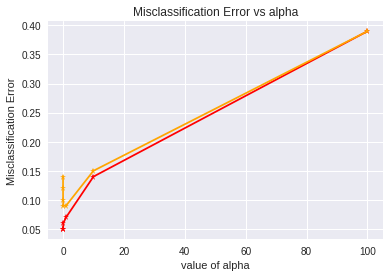

0.1

In [0]:
naive_bayes(X_train_bow,y_train,X_test_bow,y_test)

Accuracy Score :  89.9032260748729
Precision Score :  94.18241642798387
Recall Score :  93.81608174144824
F1 Score :  93.99889216403885
        
Classification Report
              precision    recall  f1-score   support

           0       0.68      0.69      0.68     18882
           1       0.94      0.94      0.94    101295

   micro avg       0.90      0.90      0.90    120177
   macro avg       0.81      0.81      0.81    120177
weighted avg       0.90      0.90      0.90    120177

        
AUC Score for train data  with roc_curve 2nd parameter as Predict : 0.8474912507015196
AUC Score for test data with roc_curve 2nd parameter as Predict : 0.813641366232927
        
AUC Score for train data  with roc_curve 2nd parameter as PredictProba : 0.941883420826886
AUC Score for test data with roc_curve 2nd parameter as PredictProba : 0.9117527434509669
        
RoC Score predict  ::  0.813641366232927
RoC Score predictproba  ::  0.9117527434509669


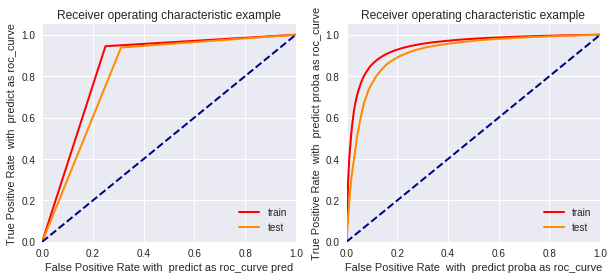

       

TrueNegative : 13012
FalsePostive : 5870
FalseNegative : 6264
TruePostive  :  95031
        
        


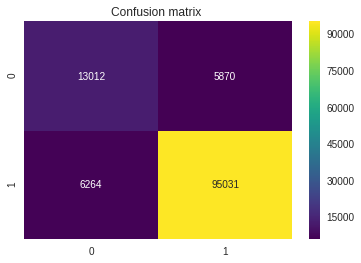

In [11]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB


clf1= MultinomialNB(alpha = 0.1)
clf1.fit(X_train_bow,y_train)
pred_train=clf1.predict(X_train_bow)
pred=clf1.predict(X_test_bow)

print("Accuracy Score : ",accuracy_score(y_test,pred)*100)
print("Precision Score : ",precision_score(y_test,pred)*100)
print("Recall Score : ",recall_score(y_test,pred)*100)
print("F1 Score : ",f1_score(y_test,pred)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred))
print("        ")  


fpr_train_pred,tpr_train_pred,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data  with roc_curve 2nd parameter as Predict :",metrics.auc(fpr_train_pred,tpr_train_pred))

fpr_pred,tpr_pred,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data with roc_curve 2nd parameter as Predict :",metrics.auc(fpr_pred,tpr_pred))

print("        ")  

pred_proba=clf1.predict_proba(X_test_bow)
pred_proba_train=clf1.predict_proba(X_train_bow)

fpr_train_pred_proba,tpr_train_pred_proba,thresholds_train=roc_curve(y_train,pred_proba_train[:,1])
print("AUC Score for train data  with roc_curve 2nd parameter as PredictProba :",metrics.auc(fpr_train_pred_proba,tpr_train_pred_proba))

fpr_pred_proba,tpr_pred_proba,thresholds=roc_curve(y_test,pred_proba[:,1])
print("AUC Score for test data with roc_curve 2nd parameter as PredictProba :",metrics.auc(fpr_pred_proba,tpr_pred_proba))


print("        ")  

#y_true = # ground truth labels
#y_probas = # predicted probabilities generated by sklearn classifier
#skplt.metrics.plot_roc_curve(y_true, y_probas)
#plt.show()

pred_proba=clf1.predict_proba(X_test_bow)
print("RoC Score predict  :: ",roc_auc_score(y_test, pred))

print("RoC Score predictproba  :: ",roc_auc_score(y_test, pred_proba[:,1]))




plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(fpr_train_pred, tpr_train_pred,color='red',lw=2,label='train')
plt.plot(fpr_pred, tpr_pred,color='darkorange',lw=2,label='test')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate with  predict as roc_curve pred')
plt.ylabel('True Positive Rate  with  predict as roc_curve')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.subplot(122)
plt.plot(fpr_train_pred_proba, tpr_train_pred_proba,color='red',lw=2,label='train')
plt.plot(fpr_pred_proba, tpr_pred_proba,color='darkorange',lw=2,label='test')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate  with  predict proba as roc_curve')
plt.ylabel('True Positive Rate  with  predict proba as roc_curve')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()




print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()


### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [12]:
features_name = count_vect.get_feature_names()
   
feat_count = clf1.feature_count_
#print("printing features score on class 0 and class 1 is :",feat_count)
print("printing features score  rows {} and columns {} :".format(feat_count.shape[0],feat_count.shape[1]))
    #print(nb_optimal.class_count_)
    
    #Feature probablity for a paticular class get by (feature_log_prob_ or feature_count_ Attribute )
log_prob = clf1.feature_log_prob_
#print("printing probablity of features on class 0 and class 1 is : ",log_prob)

print("No.of Rows and column in log_prob : ",log_prob.shape)
print("Total number of features : ",len(features_name))

    #creating DataFrame with each word probabilty value  
    #ie feature or word name(By bow_features )
    #ie each feature or word probablity value(score) of each class by feature_log_prob_
feature_prob = pd.DataFrame(feat_count, columns = features_name,index=['negative','postive'])
feature_prob
feature_prob_transpose = feature_prob.T
print("Dataframe for feature_Importance contain rows {},columns {}".format(feature_prob_transpose.shape[0],feature_prob_transpose.shape[1]))
    
print("Top 20 Postive features : \n", feature_prob_transpose['postive'].sort_values(ascending = False)[:20])


printing features score  rows 2 and columns 49398 :
No.of Rows and column in log_prob :  (2, 49398)
Total number of features :  49398
Dataframe for feature_Importance contain rows 49398,columns 2
Top 20 Postive features : 
 like       92448.0
tast       84331.0
good       73484.0
love       71364.0
flavor     71080.0
use        68635.0
great      67658.0
veri       60157.0
product    59035.0
just       58240.0
tri        57164.0
tea        54815.0
coffe      51768.0
make       49732.0
food       42219.0
buy        35874.0
time       35854.0
realli     35104.0
eat        34352.0
onli       34098.0
Name: postive, dtype: float64


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [0]:
print("Top 20 Negative features : \n", feature_prob_transpose['negative'].sort_values(ascending = False)[:20])

Top 20 Negative features : 
 tast       22573.0
like       21569.0
product    18328.0
flavor     12649.0
just       12283.0
tri        11821.0
veri       11230.0
use        10125.0
coffe       9743.0
good        9731.0
buy         8995.0
order       8529.0
food        8165.0
dont        7741.0
tea         7558.0
box         6969.0
becaus      6800.0
onli        6720.0
make        6483.0
time        6394.0
Name: negative, dtype: float64


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_df=0.95,stop_words='english',max_features=50000 )
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X_train_tfidf= tf_idf_vect.transform(X_train)
print("the type of count vectorizer ",type(X_train_tfidf))
print("the shape of out text TFIDF vectorizer ",X_train_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_tfidf.get_shape()[1])

X_test_tfidf = tf_idf_vect.transform(X_test)
print("the type of count vectorizer ",type(X_test_tfidf))
print("the shape of out text TFIDF vectorizer ",X_test_tfidf.get_shape())
print("the number of unique words ", X_test_tfidf.get_shape()[1])


some sample features(unique words in the corpus) ['aafco', 'aback', 'abandon', 'abc', 'abdomin', 'abil', 'abil make', 'abl', 'abl add', 'abl amazon']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (243994, 50000)
the number of unique words including both unigrams and bigrams  50000
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (120177, 50000)
the number of unique words  50000


100%|██████████| 7/7 [00:37<00:00,  5.33s/it]



The optimal number of alpha is 0.


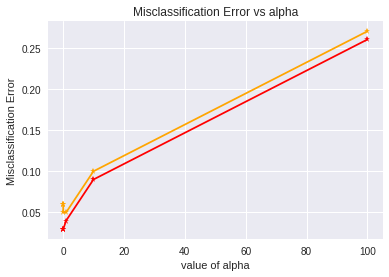

0.1

In [0]:
naive_bayes(X_train_tfidf,y_train,X_test_tfidf,y_test)

100%|██████████| 7/7 [00:31<00:00,  4.40s/it]



The optimal number of alpha is 0.


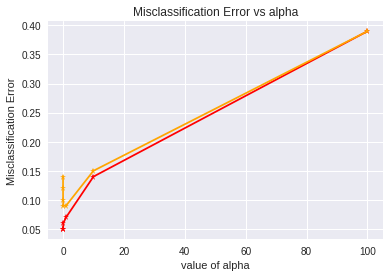

Accuracy Score :  90.87013322016692
Precision Score :  91.18883670025994
Recall Score :  98.70576040278395
F1 Score :  94.79852090641889
        
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.49      0.63     18882
           1       0.91      0.99      0.95    101295

   micro avg       0.91      0.91      0.91    120177
   macro avg       0.89      0.74      0.79    120177
weighted avg       0.91      0.91      0.90    120177

        
AUC Score for train data  with roc_curve 2nd parameter as Predict : 0.7720611854002382
AUC Score for test data with roc_curve 2nd parameter as Predict : 0.73770314795185
        
AUC Score for train data  with roc_curve 2nd parameter as PredictProba : 0.9657689486098211
AUC Score for test data with roc_curve 2nd parameter as PredictProba : 0.9481309134411939
        
RoC Score predict  ::  0.73770314795185
RoC Score predictproba  ::  0.9481309134411939


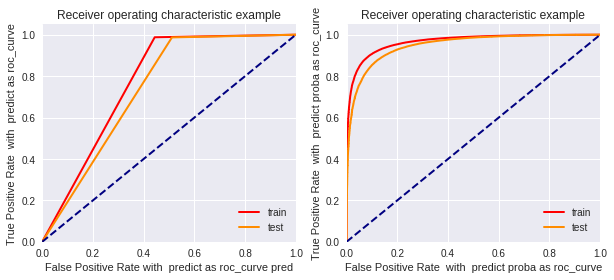

       

TrueNegative : 9221
FalsePostive : 9661
FalseNegative : 1311
TruePostive  :  99984
        
        


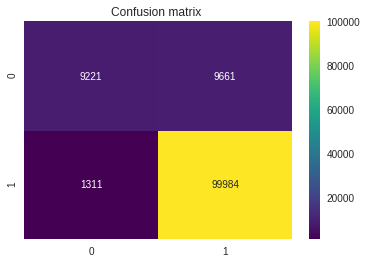

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
 


clf1= MultinomialNB(alpha = naive_bayes(X_train_bow,y_train,X_test_bow,y_test))
clf1.fit(X_train_tfidf,y_train)
pred_train=clf1.predict(X_train_tfidf)
pred=clf1.predict(X_test_tfidf)

print("Accuracy Score : ",accuracy_score(y_test,pred)*100)
print("Precision Score : ",precision_score(y_test,pred)*100)
print("Recall Score : ",recall_score(y_test,pred)*100)
print("F1 Score : ",f1_score(y_test,pred)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred))
print("        ")  


fpr_train_pred,tpr_train_pred,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data  with roc_curve 2nd parameter as Predict :",metrics.auc(fpr_train_pred,tpr_train_pred))

fpr_pred,tpr_pred,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data with roc_curve 2nd parameter as Predict :",metrics.auc(fpr_pred,tpr_pred))

print("        ")  

pred_proba=clf1.predict_proba(X_test_tfidf)
pred_proba_train=clf1.predict_proba(X_train_tfidf)

fpr_train_pred_proba,tpr_train_pred_proba,thresholds_train=roc_curve(y_train,pred_proba_train[:,1])
print("AUC Score for train data  with roc_curve 2nd parameter as PredictProba :",metrics.auc(fpr_train_pred_proba,tpr_train_pred_proba))

fpr_pred_proba,tpr_pred_proba,thresholds=roc_curve(y_test,pred_proba[:,1])
print("AUC Score for test data with roc_curve 2nd parameter as PredictProba :",metrics.auc(fpr_pred_proba,tpr_pred_proba))


print("        ")  

#y_true = # ground truth labels
#y_probas = # predicted probabilities generated by sklearn classifier
#skplt.metrics.plot_roc_curve(y_true, y_probas)
#plt.show()

pred_proba=clf1.predict_proba(X_test_tfidf)
print("RoC Score predict  :: ",roc_auc_score(y_test, pred))

print("RoC Score predictproba  :: ",roc_auc_score(y_test, pred_proba[:,1]))




plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(fpr_train_pred, tpr_train_pred,color='red',lw=2,label='train')
plt.plot(fpr_pred, tpr_pred,color='darkorange',lw=2,label='test')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate with  predict as roc_curve pred')
plt.ylabel('True Positive Rate  with  predict as roc_curve')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.subplot(122)
plt.plot(fpr_train_pred_proba, tpr_train_pred_proba,color='red',lw=2,label='train')
plt.plot(fpr_pred_proba, tpr_pred_proba,color='darkorange',lw=2,label='test')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate  with  predict proba as roc_curve')
plt.ylabel('True Positive Rate  with  predict proba as roc_curve')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()




print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()


### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [0]:
features_name = tf_idf_vect.get_feature_names()
   
feat_count = clf1.feature_count_
#print("printing features score on class 0 and class 1 is :",feat_count)
print("printing features score  rows {} and columns {} :".format(feat_count.shape[0],feat_count.shape[1]))
    #print(nb_optimal.class_count_)
    
    #Feature probablity for a paticular class get by (feature_log_prob_ or feature_count_ Attribute )
log_prob = clf1.feature_log_prob_
#print("printing probablity of features on class 0 and class 1 is : ",log_prob)

print("No.of Rows and column in log_prob : ",log_prob.shape)
print("Total number of features : ",len(features_name))

    #creating DataFrame with each word probabilty value  
    #ie feature or word name(By bow_features )
    #ie each feature or word probablity value(score) of each class by feature_log_prob_
feature_prob = pd.DataFrame(feat_count, columns = features_name,index=['negative','postive'])
feature_prob
feature_prob_transpose = feature_prob.T
print("Dataframe for feature_Importance contain rows {},columns {}".format(feature_prob_transpose.shape[0],feature_prob_transpose.shape[1]))
    
print("Top 20 Postive features : \n", feature_prob_transpose['postive'].sort_values(ascending = False)[:20])


printing features score  rows 2 and columns 50000 :
No.of Rows and column in log_prob :  (2, 50000)
Total number of features :  50000
Dataframe for feature_Importance contain rows 50000,columns 2
Top 20 Postive features : 
 love       4183.646829
great      4125.356815
like       3958.787766
tast       3920.160674
good       3897.722163
flavor     3623.042327
tea        3620.651829
coffe      3517.758644
use        3405.913935
product    3326.233755
veri       3312.847763
just       2900.210631
tri        2863.649954
make       2667.259052
food       2383.138801
best       2350.310181
buy        2330.421221
price      2293.076359
order      2210.567647
realli     2176.764949
Name: postive, dtype: float64


In [0]:
feature_prob_transpose

,negative,postive
aafco,0.947531,1.906845
aback,1.117783,4.204955
abandon,2.434199,7.585749
abc,1.991237,4.653120
abdomin,3.703658,3.146549
abil,4.919758,43.786671
abil make,0.128122,4.264919
abl,75.152074,656.068624
abl add,0.479430,5.750315
abl amazon,0.104561,25.762454


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [0]:
print("Top 20 Negative features : \n", feature_prob_transpose['negative'].sort_values(ascending = False)[:20])

Top 20 Negative features : 
 tast          1042.969769
like           933.261051
product        929.710468
flavor         621.432503
coffe          621.338371
veri           592.132235
just           585.193077
tri            572.218851
order          568.273353
buy            565.355694
box            495.721239
dont           474.230702
disappoint     473.555605
tea            471.593348
use            467.222169
good           466.385264
food           427.551118
bag            419.384582
bad            404.428912
purchas        398.204799
Name: negative, dtype: float64


# [6] Conclusions

In [0]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["NavieBayes with Different Vectorization", "alpha" , 'Test_Accuracy','F1-Score','AUC_Score on TestData with Predict', 'AUC_Score on TestData with PredictProba']

x.add_row([ "NaiveBayes with BOW" , "0.1" , 89.903  , 93.998  ,  81.36 ,91.17 ])
x.add_row([ "NaiveBayes with TFIDF" , "0" , 90.8701  , 94.798 ,  73.77 ,94.813 ])

print(x)

+-----------------------------------------+-------+---------------+----------+------------------------------------+-----------------------------------------+
| NavieBayes with Different Vectorization | alpha | Test_Accuracy | F1-Score | AUC_Score on TestData with Predict | AUC_Score on TestData with PredictProba |
+-----------------------------------------+-------+---------------+----------+------------------------------------+-----------------------------------------+
|           NaiveBayes with BOW           |  0.1  |     89.903    |  93.998  |               81.36                |                  91.17                  |
|          NaiveBayes with TFIDF          |   0   |    90.8701    |  94.798  |               73.77                |                  94.813                 |
+-----------------------------------------+-------+---------------+----------+------------------------------------+-----------------------------------------+


*  Amzon Fine food reviews with NavieBayes BOW have less AUC Score compare to the TFIDF
*  Feature Importance of TF-idf and Bow have almost same
* after using all data in AmzonFinefoodreviews got AUC SCore has 94.813
* there i no OVERFIT  or UNDERFIT in NavieBayes BOW as 
   * AUC Score for train data 0.8474912507015196
   * AUC Score for test data : 0.813641366232927 there values are good enough
* Similray there ia also not OVERFIT or UNDERFIT in NavieBayes  TFIDF  as : 
    * AUC Score for train data 0.7720611854002382
    * AUC Score for test data  : 0.73770314795185